### 14.2.2 PCA 모델 구현하기

#### 고유값 분해를 이용한 방법

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

X, y = load_iris(return_X_y=True)

In [2]:
X_centered = X - np.mean(X, axis=0)
X_cov = np.cov(X_centered.T)
eigenvalue, eigenvector = np.linalg.eigh(X_cov)

ind = np.argsort(eigenvalue)[::-1]
eigenvalue_sorted = eigenvalue[ind]
eigenvector_sorted = eigenvector[:, ind]

In [3]:
num_components = 2
eigenvector_extracted = eigenvector_sorted[:, :num_components]

X_extracted_eigen = np.dot(eigenvector_extracted.transpose(),
                           X_centered.transpose()).transpose()
print('축소된 피처 행렬의 크기:', X_extracted_eigen.shape, '\n')
print('축소된 피처 행렬의 첫 5개 샘플:\n', X_extracted_eigen[:5, :])

축소된 피처 행렬의 크기: (150, 2) 

축소된 피처 행렬의 첫 5개 샘플:
 [[ 2.68412563  0.31939725]
 [ 2.71414169 -0.17700123]
 [ 2.88899057 -0.14494943]
 [ 2.74534286 -0.31829898]
 [ 2.72871654  0.32675451]]


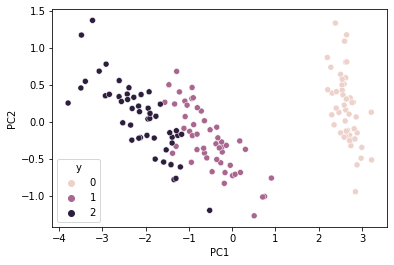

In [4]:
df = pd.DataFrame(X_extracted_eigen, columns=['PC1', 'PC2'])
df['y'] = y

sns.scatterplot(data=df, x='PC1', y='PC2', hue='y')

#### SVD를 이용한 방법

In [5]:
from numpy.linalg import svd

u, s, vh = np.linalg.svd(X_centered)

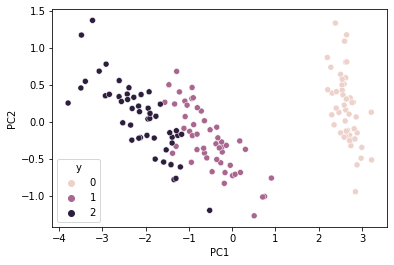

In [6]:
X_extracted_svd = -(X_centered @ vh.T)[:, :2]
df = pd.DataFrame(X_extracted_svd, columns=['PC1', 'PC2']) 
df['y'] = y

sns.scatterplot(data=df, x='PC1', y='PC2', hue='y')

In [7]:
np.allclose(X_extracted_eigen, X_extracted_svd)

True

### [예제 14.1] Pipeline을 이용한 PCA와 로지스틱 회귀 모델의 순차 적용하기

In [8]:
# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
%matplotlib inline

X, y = load_digits(return_X_y=True)

In [9]:
scaler = StandardScaler()
pca = PCA(random_state=1234)
logistic = LogisticRegression(max_iter=10000, tol=0.1, random_state=1234)

pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logistic)])

In [10]:
param_grid = {
    'pca__n_components': [5, 15, 30, 45, 60],
    'logistic__C': np.logspace(-4, 4, 4)
}
search = GridSearchCV(pipe, param_grid)
search.fit(X, y)

print('Best parameter (CV score', search.best_score_, '):',
      search.best_params_)

Best parameter (CV score 0.9237759207675642 ): {'logistic__C': 0.046415888336127774, 'pca__n_components': 60}


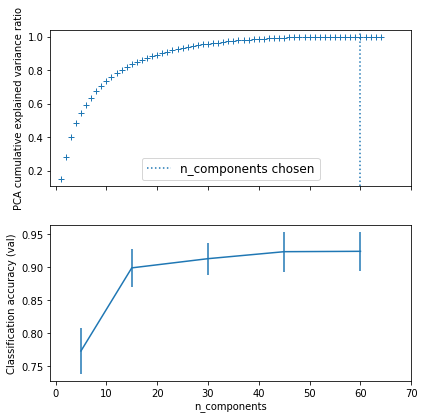

In [11]:
pca.fit(X)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         np.cumsum(pca.explained_variance_ratio_),
         "+",
         linewidth=2)
ax0.set_ylabel("PCA cumulative explained variance ratio")

ax0.axvline(search.best_estimator_.named_steps["pca"].n_components,
            linestyle=":",
            label="n_components chosen")
ax0.legend(prop=dict(size=12))

results = pd.DataFrame(search.cv_results_)
components_col = "param_pca__n_components"
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, "mean_test_score"))

best_clfs.plot(x=components_col,
               y="mean_test_score",
               yerr="std_test_score",
               legend=False,
               ax=ax1)
ax1.set_ylabel("Classification accuracy (val)")
ax1.set_xlabel("n_components")

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()

### [예제 14.2] 차원 축소 기법 사용하기

In [12]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, Isomap, LocallyLinearEmbedding, TSNE
from sklearn.pipeline import make_pipeline
%matplotlib inline

df = load_digits(as_frame=True)['frame'].sample(frac=0.1, random_state=1234)
X, y = df.drop(['target'], axis=1), df['target']

In [13]:
pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=1234))
mds = make_pipeline(StandardScaler(), MDS(n_components=2, random_state=1234))
isomap = make_pipeline(StandardScaler(), Isomap(n_components=2))
lle = make_pipeline(StandardScaler(),
                    LocallyLinearEmbedding(n_components=2, random_state=1234))
tsne = make_pipeline(StandardScaler(), TSNE(n_components=2, random_state=1234))

methods = [("PCA", pca), ("MDS", mds), ("Isomap", isomap), ("LLE", lle), 
           ("TSNE", tsne)]

c:\users\giwoong\appdata\local\programs\python\python37\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\users\giwoong\appdata\local\programs\python\python37\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


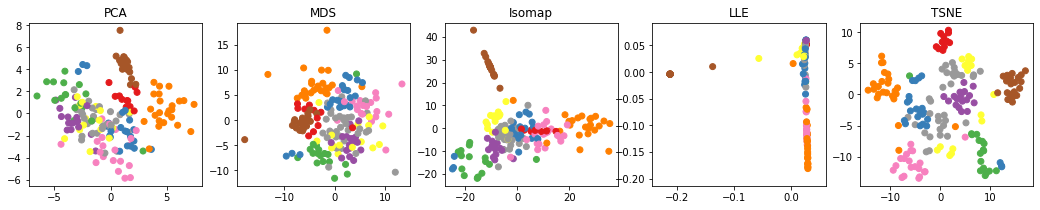

In [14]:
fig, axs = plt.subplots(1, 5, figsize=(18, 3))
for i, (name, model) in enumerate(methods):
    X_embedded = model.fit_transform(X)
    axs[i].scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap="Set1")
    axs[i].set_title(name)

## 14 되새김 문제

### [되새김 문제 14.1] PCA 클래스 적용하기

#### 문제

In [15]:
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

X, _ = load_wine(return_X_y=True)

#### 풀이

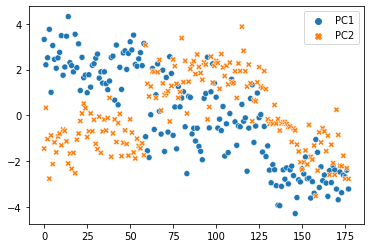

In [16]:
X = StandardScaler().fit_transform(X)

pca = PCA(n_components=2, random_state=1234)

X_extracted = pca.fit_transform(X)
X_extracted = pd.DataFrame(X_extracted, columns=['PC1', 'PC2'])

sns.scatterplot(data=X_extracted)

### [되새김 문제 14.2] 차원 축소 기법 비교하기

#### 문제

In [17]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, Isomap, LocallyLinearEmbedding, TSNE
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
import warnings

warnings.filterwarnings("ignore")

df = load_digits(as_frame=True)['frame'].sample(frac=0.1, random_state=1234)
X, y = df.drop(['target'], axis=1), df['target']

#### 풀이

In [18]:
pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=1234))
mds = make_pipeline(StandardScaler(), MDS(n_components=2, random_state=1234))
isomap = make_pipeline(StandardScaler(), Isomap(n_components=2))
lle = make_pipeline(StandardScaler(), 
                    LocallyLinearEmbedding(n_components=2, random_state=1234))
tsne = make_pipeline(StandardScaler(), TSNE(n_components=2, random_state=1234))

methods = [("PCA", pca), ("MDS", mds), ("Isomap", isomap), ("LLE", lle), 
           ("TSNE", tsne)]

for (name, model) in methods:
    X_transformed = model.fit_transform(X)
    clf = LogisticRegression(random_state=1234).fit(X_transformed, y)
    y_pred = clf.predict(X_transformed)
    
    acc = (y == y_pred).mean() * 100
    print(f'{name} 모델의 정확도: {acc:.2f}%')

PCA 모델의 정확도: 64.44%
MDS 모델의 정확도: 65.56%
Isomap 모델의 정확도: 68.89%
LLE 모델의 정확도: 32.78%
TSNE 모델의 정확도: 76.11%
